<a href="https://colab.research.google.com/github/AHamamd150/Zewail-city/blob/main/Hybrid_Quantum_classical_deepmodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
pip install pennylane --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import os # To use the system comands in python
import matplotlib.pyplot as plt # plotting library
import numpy as np  #Numerical python liberary
import pandas as pd #Data handeling python module 
plt.style.use('seaborn')
import pennylane as qml 
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt
import tensorflow as tf

tf.keras.backend.set_floatx('float64')

In [23]:
!git clone https://github.com/AHamamd150/Zewail-city.git


fatal: destination path 'Zewail-city' already exists and is not an empty directory.


In [24]:
columns=['dr','met','ptj1','etaj1','ptj2','etaj2','ptZ','etaZ']
bkg=pd.DataFrame(np.load('Zewail-city/data/bkg.npz',allow_pickle=True)['arr_0'].T,columns=columns)
sig=pd.DataFrame(np.load('Zewail-city/data/Signal.npz',allow_pickle=True)['arr_0'].T,columns=columns)

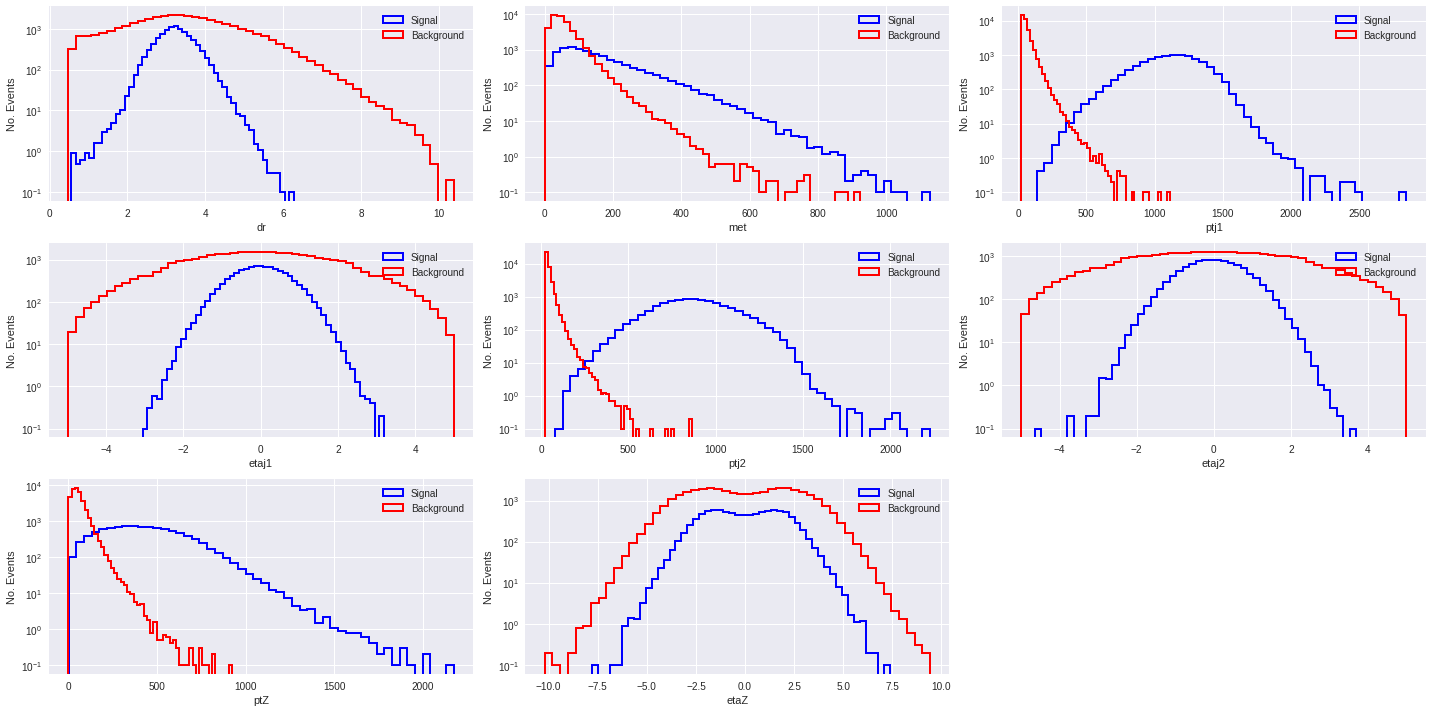

In [25]:
signal_weight = 0.1 #weight of the signal events
bkg_weight = 0.1 # Weight of the background events
##########
fig= plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=1, wspace=1)
for q in range(8):
    y= fig.add_subplot(3,3,q+1)
    y.hist(sig.iloc[:,q],bins=50,fill=False,histtype='step',weights=np.ones(len((sig.iloc[:,q])))*signal_weight,log=True,label='Signal',linewidth=2,color='b');
    y.hist(bkg.iloc[:,q],bins=50,fill=False,histtype='step',weights=np.ones(len((bkg.iloc[:,q])))*bkg_weight,log=True,label='Background',linewidth=2,color='r');
    y.set_xlabel(columns[q]);
    y.set_ylabel('No. Events');
    plt.legend(loc='best',fontsize=10);
    plt.tight_layout()


In [26]:
sig['label']=np.ones(sig.shape[0])
bkg['label']=np.zeros(bkg.shape[0])

In [27]:
df = pd.concat([sig[:100],bkg[:100]],ignore_index=True) 

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:-1],df.iloc[:,-1],stratify=df.iloc[:,-1],test_size=0.2)

In [29]:
print('train sample shape= ',X_train.shape,' and test sample shape= ',X_test.shape)
print('train label shape= ',y_train.shape,'\t and test label shape= ',y_test.shape)

train sample shape=  (160, 8)  and test sample shape=  (40, 8)
train label shape=  (160,) 	 and test label shape=  (40,)


In [30]:
from sklearn.preprocessing import StandardScaler
Sc = StandardScaler()
X_train = Sc.fit_transform(X_train)
X_test = Sc.transform(X_test)
y_train=tf.keras.utils.to_categorical(y_train,2)
y_test=tf.keras.utils.to_categorical(y_test,2)

In [31]:
n_qubits = 4
n_layers = 1
weights_init = 0.0 * np.random.randn(n_layers, n_qubits,3, requires_grad=True)#Initialize the weights

# Define the quantum layers 

In [32]:
dev = qml.device("default.qubit",wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]


# plot the quantum layers alone

/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


(<Figure size 1512x360 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fbfe7d77490>)

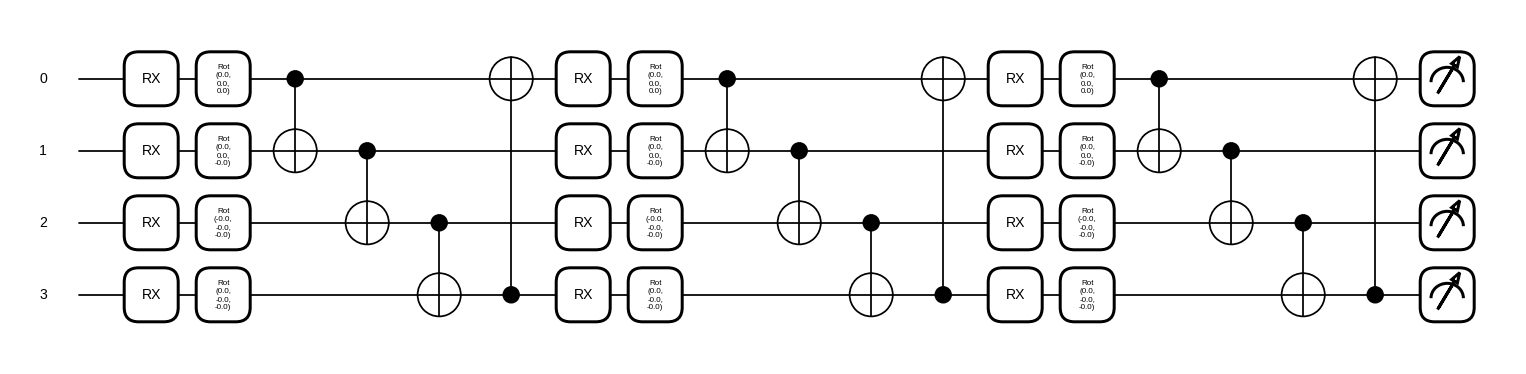

In [33]:
qml.draw_mpl(qnode,expansion_strategy="device",decimals=1)(X_train[:,:4],weights_init)

# Sequantial Quantum-Classical model

In [42]:
weight_shapes = {"weights": (n_layers, n_qubits,3)} # It is important to adjust the shape of the weights, while 3 stands for the three rotated angles
# re-define the layers
clayer_1 = tf.keras.layers.Dense(4,name='Classical_Layer')
qlayer_1 = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits,name='Quantum_Layer')
clayer_2 = tf.keras.layers.Dense(2, activation="softmax",name="Classical_output")

# construct the model
inputs = tf.keras.Input(shape=(8,))
x = clayer_1(inputs)
x1 = qlayer_1(x)
outputs = clayer_2(x1)

model1 = tf.keras.Model(inputs=inputs, outputs=outputs)


# Plot the model

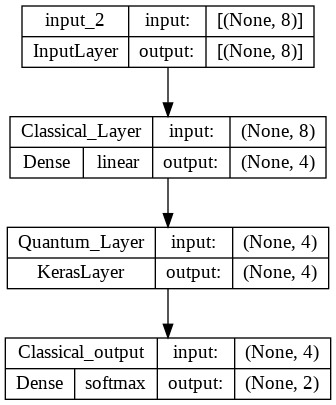

In [39]:
tf.keras.utils.plot_model(model1,show_shapes=True,show_layer_names=True,show_layer_activations=True)

In [40]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.2), loss='CategoricalCrossentropy', metrics=["accuracy"])

In [41]:
fitting = model1.fit(X_train, y_train, epochs=2, batch_size=10, validation_split=0.2, verbose=1)


Epoch 1/2
13/13 [==============================] - 32s 2s/step - loss: 0.6957 - accuracy: 0.5234 - val_loss: 0.6712 - val_accuracy: 0.5938
Epoch 2/2
13/13 [==============================] - 42s 3s/step - loss: 0.6901 - accuracy: 0.6172 - val_loss: 0.7915 - val_accuracy: 0.3750


# Non Sequential Hybrid model

In [ ]:
weight_shapes = {"weights": (n_layers, n_qubits)}
# re-define the layers
clayer_1 = tf.keras.layers.Dense(8,name='Classical_Layer')
qlayer_1 = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits,name='Quantum_Layer_1')
qlayer_2 = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits,name='Quantum_Layer_2')
clayer_2 = tf.keras.layers.Dense(2, activation="softmax")

# construct the model
inputs = tf.keras.Input(shape=(8,))
x = clayer_1(inputs)
x_1, x_2 = tf.split(x, 2, axis=1)
x_1 = qlayer_1(x_1)
x_2 = qlayer_2(x_2)
x = tf.concat([x_1, x_2], axis=1)
outputs = clayer_2(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


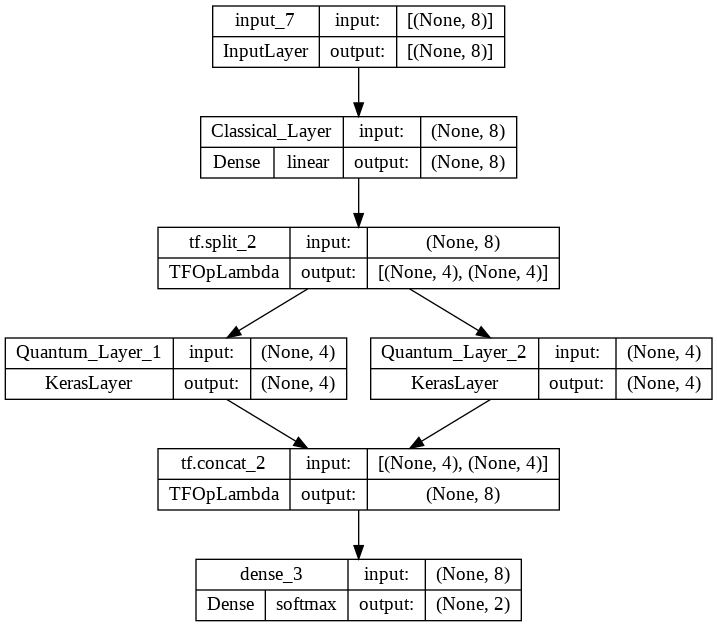

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True,show_layer_activations=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.2), loss='CategoricalCrossentropy', metrics=["accuracy"])

In [ ]:
hist = model.fit(X_train, y_train, epochs=2, batch_size=10, validation_split=0.2, verbose=1)


Epoch 1/2
13/13 [==============================] - 51s 4s/step - loss: 0.2065 - accuracy: 0.9297 - val_loss: 0.1219 - val_accuracy: 0.9375
Epoch 2/2
13/13 [==============================] - 67s 5s/step - loss: 0.0334 - accuracy: 0.9922 - val_loss: 0.0831 - val_accuracy: 0.9688


# Multi-inputs Hybrid model 

In [ ]:
weight_shapes = {"weights": (n_layers, n_qubits)}
# re-define the layers
clayer1 = tf.keras.layers.Dense(4,name='Classical_Layer_1')
clayer2 = tf.keras.layers.Dense(4,name='Classical_Layer_2')
qlayer1 = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits,name='Quantum_Layer_1')
qlayer2 = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits,name='Quantum_Layer_2')
clayer3 = tf.keras.layers.Dense(2, activation="softmax")

# construct the model
inputs1 = tf.keras.Input(shape=(8,))
inputs2 = tf.keras.Input(shape=(8,))
x1 = clayer1(inputs1)
x2 = clayer2(inputs2)
X_1 = qlayer1(x1)
X_2 = qlayer2(x2)
x = tf.concat([X_1, X_2], axis=1)
outputs = clayer3(x)

model2 = tf.keras.Model(inputs=[inputs1,inputs2], outputs=outputs)


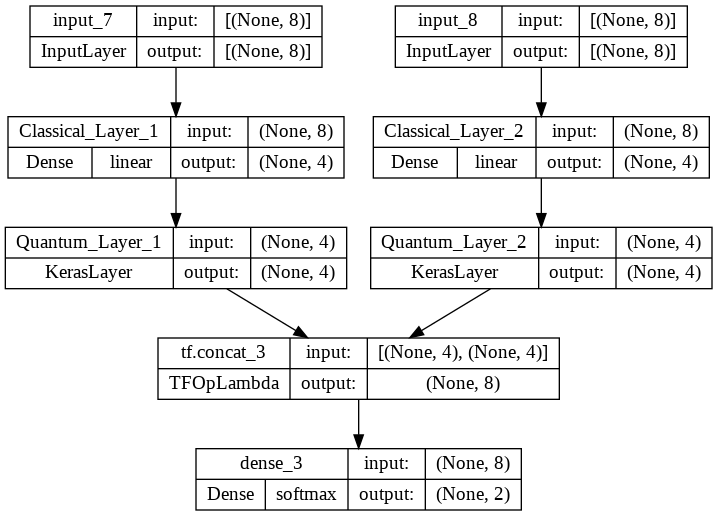

In [ ]:
tf.keras.utils.plot_model(model2,show_shapes=True,show_layer_names=True,show_layer_activations=True)

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.2), loss='CategoricalCrossentropy', metrics=["accuracy"])

In [ ]:
hist2 = model2.fit([X_train,X_train], y_train, epochs=2, batch_size=10, validation_split=0.2, verbose=1)


Epoch 1/2
13/13 [==============================] - 47s 4s/step - loss: 0.5269 - accuracy: 0.7266 - val_loss: 0.4205 - val_accuracy: 0.7500
Epoch 2/2
13/13 [==============================] - 47s 4s/step - loss: 0.3939 - accuracy: 0.8125 - val_loss: 0.0990 - val_accuracy: 1.0000
